In [1]:
import numpy as np

from blue_conduit_spatial.utilities import load_datasets, load_predictions, select_data
from blue_conduit_spatial.evaluation import generate_hit_rate_curve, generate_hit_rate_curve_by_partition, plot_hit_rate_curve

data_dir = '../data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all_bl, test_pred_all_bl = load_predictions(pred_dir, probs_prefix='baseline')
train_pred_all_diff, test_pred_all_diff = load_predictions(pred_dir, probs_prefix='diffusion')

n_hexagons = 47
train_size = 0.1
split = 0

args = {    
    'Xdata': Xdata,
    'Ydata': Ydata,
    'pid': pid,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_size': train_size,
    'split': split,
    'return_pid': False
}

args_bl = args.copy()
args_bl['train_pred_all'] = train_pred_all_bl
args_bl['test_pred_all'] = test_pred_all_bl
args_bl['generate_hexagons'] = True
args_bl['n_hexagons'] = n_hexagons
args_bl['partitions_builder'] = partitions_builder

args_diff = args.copy()
args_diff['train_pred_all'] = train_pred_all_diff
args_diff['test_pred_all'] = test_pred_all_diff
args_diff['generate_hexagons'] = False

data_bl = select_data(**args_bl)
data_diff = select_data(**args_diff)

2021-11-07 21:58.26 [info     ] Generating the partition map of type 'hexagon'


100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 22492.85it/s]

2021-11-07 21:58.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-07 21:58.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-07 21:58.31 [debug    ] Total parcels after join: 26857
2021-11-07 21:58.31 [info     ] Building the connected graph on the partitions.
2021-11-07 21:58.35 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


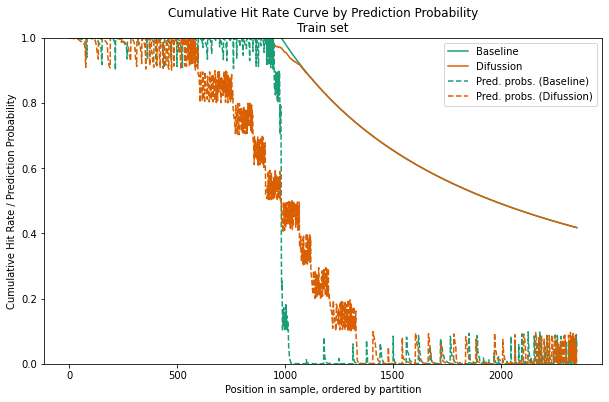

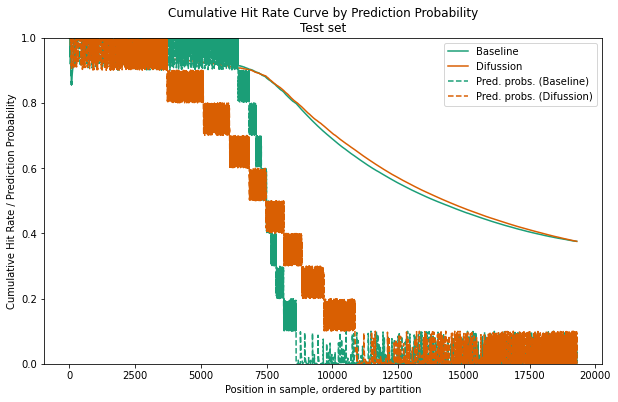

In [2]:
hexagons = data_bl['hexagons']
train_index = data_bl['train_index']
test_index = data_bl['test_index']
y_train = data_bl['Ytrain']
y_test = data_bl['Ytest']

plot_args = {
    'plot_probs': True,
    'labels':['Baseline', 'Difussion'],
    'max_perf':False,
    'order_by_prob':False,
    'figsize':(10,6),
    'savefig':False,
    'mode':'partition',
    'parcel_df':hexagons.parcel_gdf,
    'threshold_init':0.9
}

plot_args_train = plot_args.copy()
plot_args_train['y_true'] = y_train
plot_args_train['y_pred'] = [data_bl['train_pred'], data_diff['train_pred']]
plot_args_train['index_list'] = train_index
plot_args_train['title_suffix'] = 'Train set'

plot_args_test = plot_args.copy()
plot_args_test['y_true'] = y_test
plot_args_test['y_pred'] = [data_bl['test_pred'], data_diff['test_pred']]
plot_args_test['index_list'] = test_index
plot_args_test['title_suffix'] = 'Test set'

plot_hit_rate_curve(**plot_args_train)
plot_hit_rate_curve(**plot_args_test)

In [32]:
hr_args = {
    'parcel_df':hexagons.parcel_gdf,
    'threshold_init':0.9,
    'gen_dig_metadata': True
}

hr_args_train = hr_args.copy()
hr_args_train['y_true'] = y_train
hr_args_train['index_list'] = train_index

hr_args_train_bl = hr_args_train.copy()
hr_args_train_bl['y_pred'] = data_bl['train_pred']
hr_args_train_diff = hr_args_train.copy()
hr_args_train_diff['y_pred'] = data_diff['train_pred']

hr_args_test = hr_args.copy()
hr_args_test['y_true'] = y_test
hr_args_test['index_list'] = test_index

hr_args_test_bl = hr_args_test.copy()
hr_args_test_bl['y_pred'] = data_bl['test_pred']
hr_args_test_diff = hr_args_test.copy()
hr_args_test_diff['y_pred'] = data_diff['test_pred']

_, _, dig_metadata_train_bl = generate_hit_rate_curve_by_partition(**hr_args_train_bl)
_, _, dig_metadata_test_bl = generate_hit_rate_curve_by_partition(**hr_args_test_bl)
_, _, dig_metadata_train_diff = generate_hit_rate_curve_by_partition(**hr_args_train_diff)
_, _, dig_metadata_test_diff = generate_hit_rate_curve_by_partition(**hr_args_test_diff)

In [68]:
dig_metadata_all = [dig_metadata_test_bl, dig_metadata_test_diff]
suffix_all = ['bl', 'diffusion']

dig_metrics = None

for dig_metadata_, suffix in zip(dig_metadata_all, suffix_all):
    dig_metadata_ = dig_metadata_.groupby('dig_batch').agg({'dig_threshold': ['min'], 'true_val': ['sum', 'mean', 'count']})
    dig_metadata_.columns = ['_'.join(col) for col in dig_metadata_.columns.values]
    dig_metadata_ = dig_metadata_.rename(columns={"dig_threshold_min": "thres", "true_val_sum": "digs_lead", "true_val_count":"digs",  "true_val_mean": 'hit_rate'})
    dig_metadata_['digs_lead'] = dig_metadata_['digs_lead'].astype(int)
    dig_metadata_['thres'] = dig_metadata_['thres'].round(2)
    dig_metadata_.columns = [col + f'_{suffix}' for col in dig_metadata_.columns.values]
    if dig_metrics is None:
        dig_metrics = dig_metadata_
    else:
        dig_metrics = dig_metrics.join(dig_metadata_, how='outer')
        
dig_metrics = dig_metrics.reindex(sorted(dig_metrics.columns), axis=1)

In [70]:
dig_metrics.iloc[:10]

,digs_bl,digs_diffusion,digs_lead_bl,digs_lead_diffusion,hit_rate_bl,hit_rate_diffusion,thres_bl,thres_diffusion
dig_batch,,,,,,,,
0,78.0,73,67.0,71,0.858974,0.972603,0.9,0.9
1,77.0,73,75.0,64,0.974026,0.876712,0.9,0.9
2,69.0,64,67.0,62,0.971014,0.968750,0.9,0.9
3,66.0,63,61.0,58,0.924242,0.920635,0.9,0.9
4,64.0,58,63.0,55,0.984375,0.948276,0.9,0.9
5,61.0,57,59.0,55,0.967213,0.964912,0.9,0.9
6,61.0,54,56.0,52,0.918033,0.962963,0.9,0.9
7,58.0,53,58.0,52,1.000000,0.981132,0.9,0.9
8,57.0,50,55.0,47,0.964912,0.940000,0.9,0.9
